# 📈 **GRAPHS ALGORITHMS GENERATOR** 

---------------------------
### **IMPORTS**

In [2]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from math import floor, ceil

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import time
import os
import sys

src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(src_path)
from classifiers.CoForestClassifier import CoForest
from classifiers.TriTrainingClassifier import TriTraining
from classifiers.DemocraticCoCassifier import DemocraticCo
from classifiers.utils import *
from notebooks.graphs_utils import *

---------------------------
### **CLASSES**

Fit methods needs to be overwritten since graphs are generated while training, so inheritance is used.

In [3]:
class CoForest_graphs(CoForest):

    def fit(self, L, y, U, X_test, y_test):
        """
        Fits the ensemble using both labeled and
        pseudo-labeled data. Generates graphs to show 
        how score evolves during training.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Tags of the labeled data used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """

        mask_L = self.create_trees(L, y)
        scores = [self.score(X_test, y_test)]

        e = [0 for i in range(self.n)]
        W = [0 for i in range(self.n)]

        previous_e = [0.5 for i in range(self.n)]
        previous_W = [min(0.1*len(L), 100) for i in range(self.n)]

        new_data = True
        t = 0

        while new_data:

            t += 1
            tree_changes = np.array([False for i in range(self.n)])
            tree_pseudo_updates = [() for i in range(self.n)]

            for i, hi in self.ensemble.items():

                e[i] = self.concomitant_oob_error(hi, L, y, mask_L)
                W[i] = previous_W[i]
                pseudo_labeled_data = []
                pseudo_labeled_tags = []

                if e[i] < previous_e[i]:

                    if e[i] == 0:
                        Wmax = self.theta * U.shape[0]
                    else:
                        Wmax = min(
                            self.theta * U.shape[0], ((previous_e[i]*previous_W[i])/e[i]))

                    U_subsampled = self.subsample(hi, U, Wmax)
                    W[i] = 0

                    for u in U_subsampled:
                        concomitant_confidence, selected_class = self.concomitant_confidence(
                            hi, U[u, :])

                        if concomitant_confidence > self.theta:
                            tree_changes[i] = True
                            pseudo_labeled_data.append(U[u, :])
                            pseudo_labeled_tags.append(selected_class)
                            W[i] += concomitant_confidence

                tree_pseudo_updates[i] = (
                    (np.array(pseudo_labeled_data), np.array(pseudo_labeled_tags)))

            for i in np.fromiter(self.ensemble.keys(), dtype=int)[tree_changes]:
                if e[i] * W[i] < previous_e[i] * previous_W[i]:
                    self.retrain_tree(
                        i, L, y, tree_pseudo_updates[i][0], tree_pseudo_updates[i][1], mask_L)

            previous_e = deepcopy(e)
            previous_W = deepcopy(W)

            if tree_changes.sum() == 0:
                new_data = False

            scores.append(self.score(X_test, y_test))

        append_to_csv("file.csv", scores)


In [4]:
class TriTraining_graphs(TriTraining):

    def fit(self, L, y, U, X_test, y_test):
        """
        Trains the tri-training ensemble using Zhi-Hua Zhou
        Algorithm. Generates graphs to show how score
        evolves during training.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Labeled data tags used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """

        self.initialize_classifiers(L, y)
        self.classes = np.unique(y)

        previous_e = [0.5 for i in range(self.n)]
        previous_l = [0.0 for i in range(self.n)]
        e = [0.0 for i in range(self.n)]
        new_data = True

        t = 0
        scores = [self.score(X_test, y_test)]

        while new_data:

            t += 1
            cls_changes = np.array([False for i in range(self.n)])
            cls_pseudo_updates = [() for i in range(self.n)]

            for i in range(self.n):

                e[i] = self.measure_error(i, L, y)

                if e[i] < previous_e[i]:
                    cls_pseudo_updates[i] = self.create_pseudolabeled_set(i, U)

                    if previous_l[i] == 0:
                        previous_l[i] = floor(
                            (e[i] / (previous_e[i]-e[i])) + 1)

                    L_i_size = cls_pseudo_updates[i][0].shape[0]

                    if previous_l[i] < L_i_size:

                        if e[i] * L_i_size < previous_e[i] * previous_l[i]:
                            cls_changes[i] = True

                        elif previous_l[i] > (e[i] / (previous_e[i] - e[i])):

                            L_index = self.rd.choice(L_i_size, ceil(
                                (previous_e[i] * previous_l[i] / e[i]) - 1))
                            cls_pseudo_updates[i] = (
                                cls_pseudo_updates[i][0][L_index, :], cls_pseudo_updates[i][1][L_index])
                            cls_changes[i] = True

            if cls_changes.sum() == 0:
                new_data = False

            else:

                for i in np.fromiter(self.classifiers.keys(), dtype=int)[cls_changes]:

                    X_train = np.concatenate((L, cls_pseudo_updates[i][0]))
                    y_train = np.concatenate((y, cls_pseudo_updates[i][1]))
                    self.classifiers[i] = self.classifiers[i].fit(
                        X_train, y_train)

                    previous_e[i] = e[i]
                    # Tamaño de Li anterior
                    previous_l[i] = cls_pseudo_updates[i][0].shape[0]

                scores.append(self.score(X_test, y_test))

        append_to_csv("file.csv", scores)


In [5]:
class DemocraticCo_graphs(DemocraticCo):

    def fit(self, L, y, U, X_test, y_test):
        """
        Trains the democratic-Co.

        Parameters
        ----------
        L: np.array
            Labeled data used for training
        y: np.array
            Labeled data tags used for training
        U: np.array
            Unlabeled data used for training
        X_test: np.array
            samples to check evolution
        y_test: np.array
            labels of samples to check evolution
        """

        classes = np.unique(y)
        self.classes = classes
        changes = True

        e = np.zeros(self.n, dtype=float)  # [0.0 for i in range(self.n)]
        q = np.zeros(self.n, dtype=float)
        e_prime = np.zeros(self.n, dtype=float)
        q_prime = np.zeros(self.n, dtype=float)
        L_ = [(list(L), list(y)) for i in range(self.n)]
        cls_changes = np.ones(self.n, dtype=bool)

        t = 0
        scores = [self.score(X_test, y_test)]

        while changes:

            t += 1

            for i in np.arange(self.n)[cls_changes]:
                self.classifiers[i] = self.classifiers[i].fit(*L_[i])
            cls_changes = np.zeros(self.n, dtype=bool)

            U_tag_votes = [{i: set() for i in self.classes} for x in U]
            U_y = []

            for x in range(len(U)):
                for id_cls, cls in self.classifiers.items():
                    prediction = cls.predict([U[x]])[0]
                    U_tag_votes[x][prediction].add(id_cls)

                U_y.append(
                    max(U_tag_votes[x], key=lambda k: len(U_tag_votes[x].get(k))))

            # Choose which exs to propose for labeling
            w = [self.get_w(cls, L, y) for cls in self.classifiers.values()]
            L_prime = [([], []) for i in range(self.n)]

            for x in range(len(U)):

                most_voted_tag = U_y[x]
                cls_agree_tag = U_tag_votes[x][most_voted_tag]

                exp_1 = 0
                for cls in cls_agree_tag:
                    exp_1 += w[cls]

                exp_2 = 0
                for tag in classes:
                    if tag != most_voted_tag:
                        weight_tag = 0
                        for cls in U_tag_votes[x][tag]:
                            weight_tag += w[cls]
                        exp_2 = max(exp_2, weight_tag)

                if exp_1 > exp_2:
                    for id_cls in (set(self.classifiers.keys()) - cls_agree_tag):
                        Li_prime, y_Li_prime = L_prime[id_cls]
                        Li_prime.append(U[x])
                        y_Li_prime.append(U_y[x])

            # Estimate if adding this is better
            l_mean = 0
            for id_cls, cls in self.classifiers.items():
                l_mean += confidence_interval(cls,
                                              L_[id_cls][0], L_[id_cls][1])[0]
            l_mean /= self.n

            for i in range(self.n):

                Li, y_Li = L_[i]
                Li_prime, y_Li_prime = L_prime[i]
                Li_union_Li_prime = Li + Li_prime

                q[i] = len(Li) * (1 - 2 * (e[i] / len(Li))) ** 2
                e_prime[i] = (1 - l_mean) * len(Li_prime)
                q_prime[i] = len(
                    Li_union_Li_prime) * (1 - (2*(e[i] + e_prime[i]) / len(Li_union_Li_prime))) ** 2

                if q_prime[i] > q[i]:
                    cls_changes[i] = True
                    L_[i] = (Li_union_Li_prime, y_Li + y_Li_prime)
                    e[i] = e[i] + e_prime[i]

            if cls_changes.sum() == 0:
                changes = False
                self.w = [self.get_w(cls, L, y)
                          for cls in self.classifiers.values()]

            scores.append(self.score(X_test, y_test))

        append_to_csv("file.csv", scores)


In [6]:
def create_base_cls(algorithm, n=6, thetha=0.75, max_features='log2', base_cls=None, rd=np.random.RandomState(10)):

    if base_cls is None:
        base_cls = [DecisionTreeClassifier(), GaussianNB(),
                    KNeighborsClassifier(n_neighbors=3)]

    if algorithm == 'CF':
        return CoForest(n, thetha, max_features, random_state=rd)

    elif algorithm == 'CFG':
        return CoForest_graphs(n, thetha, max_features, random_state=rd)

    elif algorithm == 'TT':
        return TriTraining(base_cls[0], base_cls[1], base_cls[2], rd)

    elif algorithm == 'TTG':
        return TriTraining_graphs(base_cls[0], base_cls[1], base_cls[2], rd)

    elif algorithm == 'DC':
        return DemocraticCo(base_cls, rd)

    elif algorithm == 'DCG':
        return DemocraticCo_graphs(base_cls, rd)


----------------------------
# **GENERAL GRAPHS**

---------------------------------------------------
### **score - número de iteraciones (entrenamiento)**

In [7]:
def graph_score_iterations_train_mosaic(available, algorithm='CF', rd_number=5):

    fig, ax = plt.subplot_mosaic(
        "AAABBCC;AAADDEE", figsize=(10, 4.5), tight_layout=True)
    ax['A'].set_ylabel('accuracy')
    ax['A'].set_xlabel('iteraciones')
    max_iterations = 0

    for dataset_info in available:

        open('file.csv', 'w').close()
        X, y = dataset_info[0]
        rd = np.random.RandomState(rd_number)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(
                X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            cls = create_base_cls(algorithm + 'G', n=20, rd=rd)
            # Test used to evaluate how score changes during training
            cls.fit(L_train, Ly_train, U_train, X_test, y_test)

        mean = np.mean(create_graph_matrix("file.csv"), axis=0)
        std = np.std(create_graph_matrix("file.csv"), axis=0)

        x_ticks = [i for i in range(len(mean))]
        ax['A'].plot(mean, '-o', color=dataset_info[3],
                     linewidth=1, label=dataset_info[1])

        ax_i = ax[dataset_info[2]]
        ax_i.set_ylim([0.7, 1.05])
        ax_i.set_ylabel('accuracy')
        ax_i.set_xlabel('iteraciones')
        ax_i.set_xticks(x_ticks)
        ax_i.errorbar(x_ticks, mean, yerr=[std, np.minimum(
            std, 1-mean)], fmt='-o',  color=dataset_info[3], linewidth=1, label=dataset_info[1])
        max_iterations = max(max_iterations, len(x_ticks))

    ax['A'].set_xticks([i for i in range(max_iterations)])
    fig.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='lower center', ncol=4)
    plt.show()


------------------------------------------------
### **número elementos - tiempo entrenamiento**


In [8]:
def graph_number_elem_training_time(algorithm='CF', rd_number=10):

    fig, ax = plt.subplots()
    X, y = load_digits(return_X_y=True)

    instancias = []
    tiempos = []
    rd = np.random.RandomState(rd_number)

    for i in range(500, X.shape[0], 100):

        indexes = rd.choice(X.shape[0], replace=False, size=i)
        L_train, U_train, Ly_train, Uy_train = train_test_split(
            X[indexes], y[indexes], test_size=0.8, random_state=rd)

        cls = create_base_cls(algorithm, n=20, rd=rd)
        inicio = time.time()
        cls.fit(L_train, Ly_train, U_train)
        fin = time.time()
        instancias.append(i)
        tiempos.append((fin-inicio))

    ax.scatter(instancias, tiempos, color='r')

    model = LinearRegression()
    model.fit(np.array([[i] for i in instancias]), tiempos)
    x_new = np.linspace(425, X.shape[0], 100)
    y_new = model.predict(x_new[:, np.newaxis])

    #plt.title("Instancias - Tiempo entrenamiento")
    ax.set_ylim(bottom=0)
    ax.plot(x_new, y_new, '--k')
    ax.set_xlabel('instancias')
    ax.set_ylabel('tiempo (s)')
    plt.show()


---------------------------------------------------
### **score - % instancias entrenamiento**

In [9]:
def score_percentage_training_instances(available, algorithm='CF', rd_number=5, n_experiments=10):

    fig, ax = plt.subplots()
    rd = np.random.RandomState(rd_number)

    for dataset_info in available:

        matriz_scores = []
        X, y = dataset_info[0]

        for j in range(n_experiments):
            scores_experimento = []

            for i in np.arange(0.5, 1, 0.1):
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, train_size=i, random_state=rd, stratify=y)
                L_train, U_train, Ly_train, Uy_train = train_test_split(
                    X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
                cls = create_base_cls(algorithm, n=20, rd=rd)
                cls.fit(L_train, Ly_train, U_train)
                scores_experimento.append(cls.score(X_test, y_test))
            matriz_scores.append(scores_experimento)

        ax.plot(np.arange(0.5, 1, 0.1), np.mean(np.array(matriz_scores), axis=0),
                '-o', color=dataset_info[3], linewidth=1, label=dataset_info[1])

    # plt.title("Score - % Instancias")
    ax.set_ylabel('score')
    ax.set_xlabel('instancias (%)')
    fig.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='upper center', ncol=4)
    plt.show()


------------------------------------------------
### **coforest (especiales): scores & tiempo - número de árboles**

In [10]:
def graph_coforest_score_time(available):

    fig, ax = plt.subplot_mosaic(
        "AABB;AABB", figsize=(8, 4), tight_layout=True)

    for dataset_info in available:

        X, y = dataset_info[0]
        rd = np.random.RandomState(5)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
        matriz_scores = []
        matriz_tiempos = []

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            L_train, U_train, Ly_train, Uy_train = train_test_split(
                X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)
            scores_fold = []
            times_fold = []

            for j in [2, 3, 6, 10, 20, 40]:
                co_forest = CoForest(j, 0.75, 'log2', rd)
                inicio = time.time()
                co_forest.fit(L_train, Ly_train, U_train)
                fin = time.time()
                times_fold.append((fin-inicio))
                scores_fold.append(co_forest.score(X_test, y_test))

            matriz_scores.append(scores_fold)
            matriz_tiempos.append(times_fold)

        ax['A'].plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(
            matriz_scores), axis=0), '-o', color=dataset_info[3], linewidth=1, label=dataset_info[1])
        ax['B'].plot(np.array([2, 3, 6, 10, 20, 40]), np.mean(np.array(
            matriz_tiempos), axis=0), '-o', color=dataset_info[3], linewidth=1, label=dataset_info[1])

    ax['A'].set_ylabel('accuracy')
    ax['A'].set_xlabel('número de árboles')
    ax['B'].set_ylabel('tiempo (s)')
    ax['B'].set_xlabel('número de árboles')
    fig.legend([di[1] for di in available], bbox_to_anchor=(
        0.5, 1.0), loc='lower center', ncol=4)

    plt.show()


-------------------------------------------
# **COMPARES**

---------------------------
### **(CF) against KEEL** 🍣

In [11]:
def graphs_keel(file_root, random_number, algorithm):

    results = []

    for i in range(1, 11):

        file_train = file_root + "{}tra.csv".format(i)
        file_test = file_root + "{}tst.csv".format(i)

        L, L_tags, U = extract_training_data(file_train)
        X_test, y_test = extract_test_data(file_test)

        cls = create_base_cls(
            algorithm, rd=np.random.RandomState(random_number))
        cls.fit(L, L_tags, U)
        results.append(cls.score(X_test, y_test))

    return results


---------------------------
### **(TT) against LAMDA and SSlearn** 🍣

In [12]:
from sslearn.wrapper import TriTraining as TriTrainingSSLearn
from sslearn.wrapper import DemocraticCoLearning as DemocraticCoSSLearn
from sslearn.model_selection import artificial_ssl_dataset
from sslearn.base import get_dataset


def graph_score_fold_sslearn(algorithm='TT', rd_number=5):

    labels = ['SSLearn', 'Media SSLearn',
              'Implementación propia', 'Media implementación propia']
    x_labels = [i for i in range(1, 11)]
    rd = np.random.RandomState(rd_number)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), tight_layout=True)
    available = [(load_iris(return_X_y=True), 'Iris'),
                 (load_wine(return_X_y=True), 'Dígitos'),
                 (load_breast_cancer(return_X_y=True), 'Cáncer de mama')]
    i = 0

    for dataset in available:

        X, y = dataset[0]
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
        results = []
        results_mine = []

        for train_index, test_index in skf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            X_train_labels, y_train_labels, U, U_labels = artificial_ssl_dataset(
                X_train, y_train, label_rate=0.1)

            # SSLearn
            if algorithm == 'TT':
                model = TriTrainingSSLearn().fit(X_train_labels, y_train_labels)
            elif algorithm == 'DC':
                model = DemocraticCoSSLearn(base_estimator=[DecisionTreeClassifier(), GaussianNB(
                ), KNeighborsClassifier(n_neighbors=3)]).fit(X_train_labels, y_train_labels)

            results.append(model.score(X_test, y_test))

            # Mio (misma función que usa él internamente)
            model_mine = create_base_cls(algorithm, base_cls=[DecisionTreeClassifier(
            ), GaussianNB(), KNeighborsClassifier(n_neighbors=3)], rd=rd)
            X_mine, y_mine, U_mine = get_dataset(
                X_train_labels, y_train_labels)
            model_mine.fit(X_mine, y_mine, U_mine)
            results_mine.append(model_mine.score(X_test, y_test))

        ax_i = ax[i]
        ax_i.set_ylim([0.5, 1.05])

        mean = np.mean(results)
        ax_i.plot(x_labels, results, '-o', color='#9467bd', linewidth=1)
        ax_i.plot(x_labels, [mean for i in range(10)],
                  '--', linewidth=1, color='#9467bd')

        mean = np.mean(results_mine)
        ax_i.plot(x_labels, results_mine, 'c-o', linewidth=1)
        ax_i.plot(x_labels, [mean for i in range(10)], 'c--', linewidth=1)

        ax_i.set_ylim([0.5, 1.05])
        ax_i.set_ylabel('accuracy')
        ax_i.set_xlabel('fold')
        ax_i.set_title(dataset[1])
        i += 1
        break

    fig.legend(labels, bbox_to_anchor=(0.5, 1.0), loc='lower center', ncol=4)
    plt.plot()


# graph_score_fold_sslearn(algorithm = 'DC', rd_number=5)


In [13]:
# from LAMDA_SSL.Algorithm.Classification.Tri_Training import Tri_Training as TriTrainingLamda

# def graph_score_fold_lamda(algorithm = 'TT', rd_number = 5):

#     labels = ['LAMDA', 'Media LAMDA', 'Implementación propia', 'Media implementación propia']
#     x_labels = [i for i in range(1,11)]
#     rd = np.random.RandomState(rd_number)
#     fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3), tight_layout=True)
#     available = [   (load_iris(return_X_y=True), 'Iris'),
#                     (load_digits(return_X_y=True), 'Dígitos'),
#                     (load_breast_cancer(return_X_y=True), 'Cáncer de mama')]
#     i = 0

#     for dataset in available:

#         X, y = dataset[0]
#         skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=rd)
#         results = []
#         results_mine = []

#         for train_index, test_index in skf.split(X, y):

#             X_train, X_test = X[train_index], X[test_index]
#             y_train, y_test = y[train_index], y[test_index]
#             L_train, U_train, Ly_train, Uy_train = train_test_split(X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)

#             # LAMDA
#             model = TriTrainingLamda(DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier())
#             model.fit(L_train, Ly_train, U_train)
#             results.append(model.score(X_test, y_test))

#             # Mio
#             model_mine = TriTraining(DecisionTreeClassifier(), DecisionTreeClassifier(), DecisionTreeClassifier())
#             model_mine.fit(L_train, Ly_train, U_train)
#             results_mine.append(model_mine.score(X_test, y_test))

#         ax_i = ax[i]

#         mean = np.mean(results)
#         ax_i.plot(x_labels, results, '-o', color = '#ff7f0e', linewidth=1)
#         ax_i.plot(x_labels, [mean for i in range(10)], '--', color = '#ff7f0e', linewidth=1)

#         mean = np.mean(results_mine)
#         ax_i.plot(x_labels, results_mine, 'c-o', linewidth=1)
#         ax_i.plot(x_labels, [mean for i in range(10)], 'c--', linewidth=1)

#         ax_i.set_ylim([0.6, 1.05])
#         ax_i.set_ylabel('accuracy')
#         ax_i.set_xlabel('fold')
#         ax_i.set_title(dataset[1])
#         i += 1

#     fig.legend(labels, bbox_to_anchor=(0.5, 1.0), loc='lower center', ncol=4)
#     plt.plot()

# graph_score_fold_lamda()


-------------------------------------------------------
# **RUN ALL** 🏃🏼‍♀️

In [14]:
def run_all(algorithm='CF'):

    graph_score_fold_sslearn(algorithm)

    available = [(load_iris(return_X_y=True), 'Iris', 'B', '#2ca02c'),
                 (load_digits(return_X_y=True), 'Dígitos', 'C', '#ff7f0e'),
                 (load_wine(return_X_y=True), 'Vino', 'D', '#d62728'),
                 (load_breast_cancer(return_X_y=True), 'Cáncer de mama', 'E', '#9467bd')]

    graph_number_elem_training_time(algorithm)
    score_percentage_training_instances(available, algorithm)
    graph_score_iterations_train_mosaic(available, algorithm)

    if algorithm == 'CF':
        graph_coforest_score_time(available)
        # results = graphs_keel("iris/iris-ssl-", 5, 'CF')
        # print("IRIS vs KEEL: {}, mean: {}".format(results, np.mean(results)))

        # results = graphs_keel("wine/wine-ssl10-10-", 10, 'CF')
        # print("WINE vs KEEL: {}, mean: {}".format(results, np.mean(results)))


c:\Users\patri\source\venvs\tfg-01\lib\site-packages\statsmodels\stats\proportion.py:136: RuntimeWarning: invalid value encountered in sqrt
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))
c:\Users\patri\source\venvs\tfg-01\lib\site-packages\statsmodels\stats\proportion.py:136: RuntimeWarning: invalid value encountered in sqrt
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


KeyboardInterrupt: 

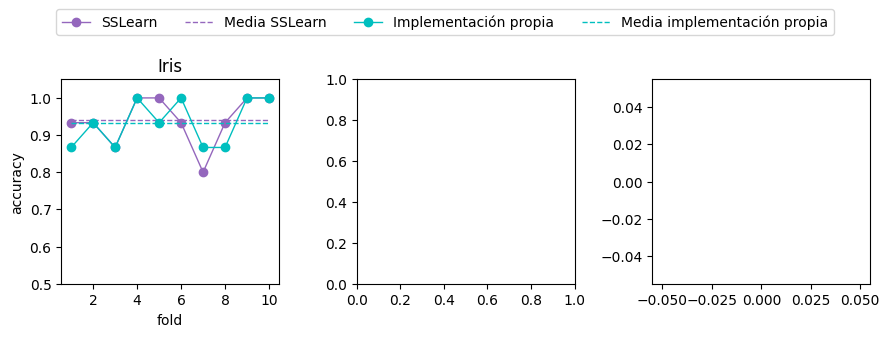

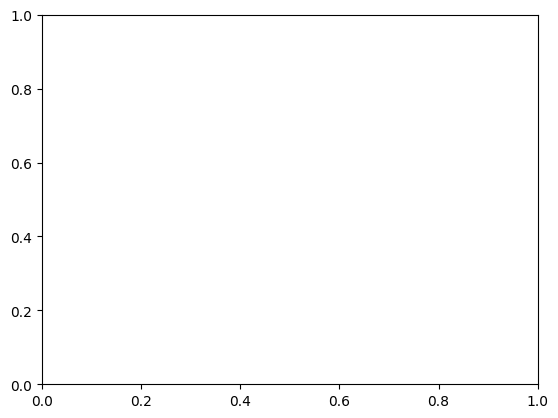

In [15]:
run_all('DC')  # 'CF', 'TT, 'DC'